<a href="https://colab.research.google.com/github/preempimpika/Assignment3_Group06_FortuneTeller/blob/main/Crow_Search_Algorithm_(CSA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import numpy as np
import matplotlib.pyplot as plt

In [61]:
# Generate 40 random cities
num_cities = 40
np.random.seed(42)  # For reproducibility
cities = np.random.rand(num_cities, 2)

# Parameters for all algorithms
max_generations = 100

# Parameters for Firefly Algorithm
num_fireflies = 200

# Parameters for Bees Algorithm
num_bees = 200
num_elite_sites = 3
num_best_sites = 7
elite_bees = 7
best_bees = 3

# Parameters for Genetic Algorithm
population_size = 200
mutation_rate = 0.02
tournament_size = 5

# Crow Search Algorithm parameters
num_crows = 200
fl = 2  # Flight length
ap = 0.7

In [62]:
# Initialize populations with random tours
fireflies = [np.random.permutation(num_cities) for _ in range(num_fireflies)]
bees = [np.random.permutation(num_cities) for _ in range(num_bees)]
population = [np.random.permutation(num_cities) for _ in range(population_size)]
crows = [np.random.permutation(num_cities) for _ in range(num_crows)]

# Initialize memory for each crow (initially set to the random positions)
memory = crows.copy()

def total_distance(tour, cities):
    """Calculate the total distance of the tour."""
    tour = tour.astype(int)
    dist = 0
    for i in range(len(tour)):
        city_a = cities[tour[i % len(tour)]]
        city_b = cities[tour[(i + 1) % len(tour)]]
        dist += np.linalg.norm(city_a - city_b)
    return dist

In [63]:
# Firefly Algorithm Implementation
best_firefly = None
best_firefly_distance = np.inf
firefly_distances_over_time = []

for gen in range(max_generations):
    # Compute the total distance (fitness) of each firefly
    distances = np.array([total_distance(firefly, cities) for firefly in fireflies])

    # Sort fireflies by their brightness (lower distance is brighter)
    indices = np.argsort(distances)
    fireflies = [fireflies[i] for i in indices]
    distances = distances[indices]

    # Update the best firefly
    if distances[0] < best_firefly_distance:
        best_firefly_distance = distances[0]
        best_firefly = fireflies[0].copy()

    firefly_distances_over_time.append(best_firefly_distance)

    # Move fireflies
    for i in range(num_fireflies):
        for j in range(num_fireflies):
            if distances[i] > distances[j]:
                # Compute attractiveness beta
                beta0 = 0.2
                gamma = 1.0
                rij = distances[i] - distances[j]
                beta = beta0 * np.exp(-gamma * (rij ** 2))

                # Move firefly i towards j
                diff_indices = np.where(fireflies[i] != fireflies[j])[0]
                num_diffs = len(diff_indices)
                if num_diffs > 0:
                    num_swaps = int(beta * num_diffs)
                    num_swaps = max(1, num_swaps)
                    swap_indices = np.random.choice(diff_indices, size=num_swaps, replace=False)
                    for idx in swap_indices:
                        city_j = fireflies[j][idx]
                        idx_in_i = np.where(fireflies[i] == city_j)[0][0]
                        # Swap positions in firefly i
                        fireflies[i][idx], fireflies[i][idx_in_i] = fireflies[i][idx_in_i], fireflies[i][idx]

    # Apply random mutation
    alpha = 0.5  # Mutation probability
    for i in range(num_fireflies):
        if np.random.rand() < alpha:
            idx1, idx2 = np.random.choice(num_cities, size=2, replace=False)
            fireflies[i][idx1], fireflies[i][idx2] = fireflies[i][idx2], fireflies[i][idx1]

In [64]:
# Bees Algorithm Implementation
best_bee = None
best_bee_distance = np.inf
bee_distances_over_time = []

for gen in range(max_generations):
    # Evaluate the fitness of each bee
    distances = np.array([total_distance(bee, cities) for bee in bees])

    # Sort bees by fitness
    indices = np.argsort(distances)
    bees = [bees[i] for i in indices]
    distances = distances[indices]

    # Update the best bee
    if distances[0] < best_bee_distance:
        best_bee_distance = distances[0]
        best_bee = bees[0].copy()

    bee_distances_over_time.append(best_bee_distance)

    # Recruit bees for elite sites
    new_bees = []
    for i in range(num_elite_sites):
        for _ in range(elite_bees):
            # Local search around the elite site
            new_tour = bees[i].copy()
            idx1, idx2 = np.random.choice(num_cities, size=2, replace=False)
            new_tour[idx1], new_tour[idx2] = new_tour[idx2], new_tour[idx1]
            new_bees.append(new_tour)

    # Recruit bees for best sites
    for i in range(num_elite_sites, num_best_sites):
        for _ in range(best_bees):
            # Local search around the best site
            new_tour = bees[i].copy()
            idx1, idx2 = np.random.choice(num_cities, size=2, replace=False)
            new_tour[idx1], new_tour[idx2] = new_tour[idx2], new_tour[idx1]
            new_bees.append(new_tour)

    # Assign remaining bees to search randomly
    remaining_bees = num_bees - len(new_bees)
    for _ in range(remaining_bees):
        new_bees.append(np.random.permutation(num_cities))

    bees = new_bees.copy()

In [65]:
# Genetic Algorithm Implementation
best_individual = None
best_individual_distance = np.inf
ga_distances_over_time = []

for gen in range(max_generations):
    # Evaluate the fitness of each individual
    distances = np.array([total_distance(individual, cities) for individual in population])

    # Update the best individual
    min_distance = distances.min()
    if min_distance < best_individual_distance:
        best_individual_distance = min_distance
        best_individual = population[distances.argmin()].copy()

    ga_distances_over_time.append(best_individual_distance)

    # Selection (Tournament Selection)
    selected = []
    for _ in range(population_size):
        indices = np.random.choice(len(population), tournament_size, replace=False)
        participants = [population[i] for i in indices]
        participant_distances = [total_distance(ind, cities) for ind in participants]
        winner = participants[np.argmin(participant_distances)]
        selected.append(winner)

    # Crossover (Order Crossover)
    offspring = []
    for i in range(0, population_size, 2):
        parent1 = selected[i]
        parent2 = selected[(i + 1) % population_size]
        cut1, cut2 = sorted(np.random.choice(num_cities, 2, replace=False))
        child1 = np.full(num_cities, -1)
        child2 = np.full(num_cities, -1)
        # Copy slice from parent to child
        child1[cut1:cut2] = parent1[cut1:cut2]
        child2[cut1:cut2] = parent2[cut1:cut2]
        # Fill remaining positions with the other parent's genes
        def fill_child(child, parent):
            fill_pos = [gene for gene in parent if gene not in child]
            idx = np.where(child == -1)[0]
            child[idx] = fill_pos
            return child
        child1 = fill_child(child1, parent2)
        child2 = fill_child(child2, parent1)
        offspring.append(child1)
        offspring.append(child2)

    # Mutation (Swap Mutation)
    for individual in offspring:
        if np.random.rand() < mutation_rate:
            idx1, idx2 = np.random.choice(num_cities, 2, replace=False)
            individual[idx1], individual[idx2] = individual[idx2], individual[idx1]

    # Update population
    population = offspring.copy()

In [66]:
best_crow = None
best_csa_distance = np.inf
csa_distances_over_time = []

for gen in range(max_generations):
    distances = np.array([total_distance(crow, cities) for crow in crows])

    # Update the best solution
    min_idx = np.argmin(distances)
    if distances[min_idx] < best_csa_distance:
        best_csa_distance = distances[min_idx]
        best_crow = crows[min_idx].copy()

    csa_distances_over_time.append(best_csa_distance)

    # Update the positions of the crows
    new_crows = []
    for i in range(num_crows):
        if np.random.rand() > ap:
            # Follow a randomly selected crow from memory
            random_crow_idx = np.random.randint(num_crows)
            memory_tour = memory[random_crow_idx]
            new_tour = crows[i].copy()
            num_changes = int(fl * num_cities)

            # Make changes to the tour based on memory
            for _ in range(num_changes):
                idx1, idx2 = np.random.choice(num_cities, size=2, replace=False)
                new_tour[idx1], new_tour[idx2] = new_tour[idx2], new_tour[idx1]

            new_crows.append(new_tour)
        else:
            # Random exploration
            new_crows.append(np.random.permutation(num_cities))

    # Update memory if the new solution is better
    for i in range(num_crows):
        if total_distance(new_crows[i], cities) < total_distance(memory[i], cities):
            memory[i] = new_crows[i].copy()

    # Replace current positions with the new positions
    crows = new_crows.copy()

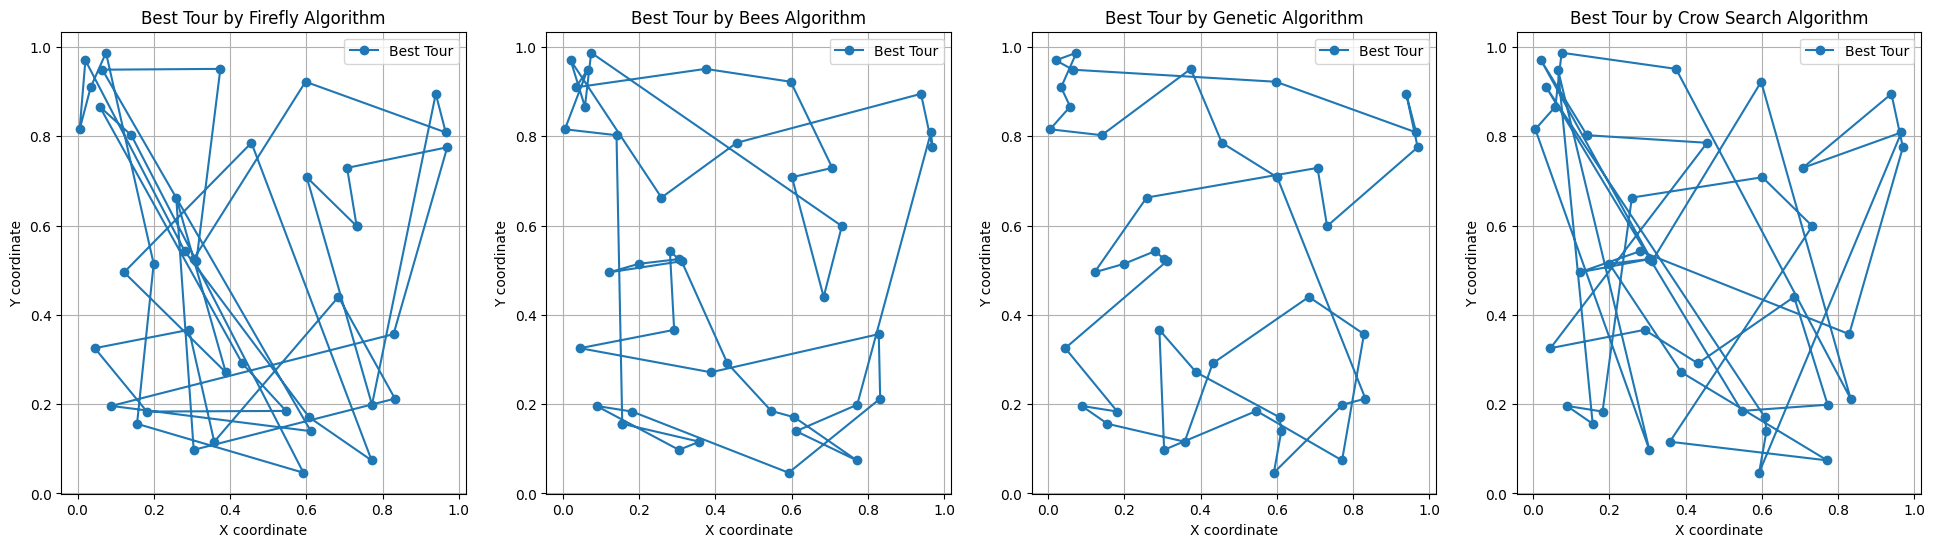

In [67]:
# Plot the best tours
fig, axs = plt.subplots(1, 4, figsize=(24, 6))

# Firefly Algorithm Result
best_tour = best_firefly
x = cities[best_tour, 0]
y = cities[best_tour, 1]
x = np.append(x, x[0])
y = np.append(y, y[0])
axs[0].plot(x, y, 'o-', label='Best Tour')
axs[0].set_title('Best Tour by Firefly Algorithm')
axs[0].set_xlabel('X coordinate')
axs[0].set_ylabel('Y coordinate')
axs[0].legend()
axs[0].grid(True)

# Bees Algorithm Result
best_tour = best_bee
x = cities[best_tour, 0]
y = cities[best_tour, 1]
x = np.append(x, x[0])
y = np.append(y, y[0])
axs[1].plot(x, y, 'o-', label='Best Tour')
axs[1].set_title('Best Tour by Bees Algorithm')
axs[1].set_xlabel('X coordinate')
axs[1].set_ylabel('Y coordinate')
axs[1].legend()
axs[1].grid(True)

# Genetic Algorithm Result
best_tour = best_individual.astype(int)
x = cities[best_tour, 0]
y = cities[best_tour, 1]
x = np.append(x, x[0])
y = np.append(y, y[0])
axs[2].plot(x, y, 'o-', label='Best Tour')
axs[2].set_title('Best Tour by Genetic Algorithm')
axs[2].set_xlabel('X coordinate')
axs[2].set_ylabel('Y coordinate')
axs[2].legend()
axs[2].grid(True)

#CSA results
best_tour = best_crow.astype(int)  # The best path found by CSA
x = cities[best_tour, 0]
y = cities[best_tour, 1]
x = np.append(x, x[0])
y = np.append(y, y[0])
axs[3].plot(x, y, 'o-', label='Best Tour')
axs[3].set_title('Best Tour by Crow Search Algorithm')
axs[3].set_xlabel('X coordinate')
axs[3].set_ylabel('Y coordinate')
axs[3].legend()
axs[3].grid(True)

plt.show()

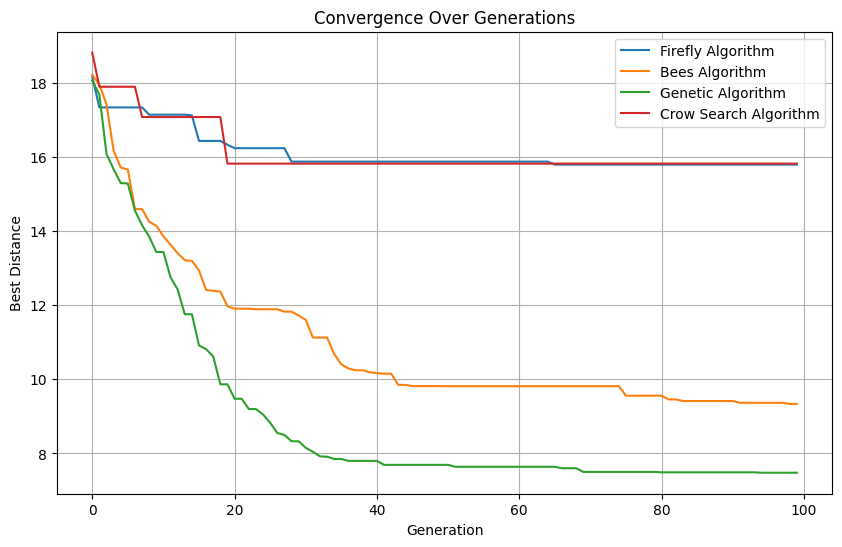

Best distance found by Firefly Algorithm: 15.7905
Best distance found by Bees Algorithm: 9.3343
Best distance found by Genetic Algorithm: 7.4796
Best distance found by Crow search Algorithm: 15.8157


In [68]:
# Plot convergence curves
plt.figure(figsize=(10,6))
plt.plot(range(max_generations), firefly_distances_over_time, label='Firefly Algorithm')
plt.plot(range(max_generations), bee_distances_over_time, label='Bees Algorithm')
plt.plot(range(max_generations), ga_distances_over_time, label='Genetic Algorithm')
plt.plot(range(max_generations), csa_distances_over_time, label='Crow Search Algorithm')
plt.title('Convergence Over Generations')
plt.xlabel('Generation')
plt.ylabel('Best Distance')
plt.legend()
plt.grid(True)
plt.show()

print(f"Best distance found by Firefly Algorithm: {best_firefly_distance:.4f}")
print(f"Best distance found by Bees Algorithm: {best_bee_distance:.4f}")
print(f"Best distance found by Genetic Algorithm: {best_individual_distance:.4f}")
print(f"Best distance found by Crow search Algorithm: {best_csa_distance:.4f}")